In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py

%matplotlib inline
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.dpi"] = 300.0

In [2]:
# load predictions from metrics hdf5 file
def load_metrics(filepath):
    hfile = h5py.File(filepath)
    gts = hfile["gts"][:]
    unet_400_preds = hfile["unet_400_preds"][:]
    unet_800_preds = hfile["unet_800_preds"][:]
    fno_400_preds = hfile["fno_400_preds"][:]
    fno_800_preds = hfile["fno_800_preds"][:]
    multistep_unet_preds = hfile["multistep_unet_preds"][:]
    mpp_zs_preds = hfile["mpp_zs_preds"][:]
    mpp_preds = hfile["mpp_preds"][:]
    refiner_preds = hfile["refiner_preds"][:]
    rl_preds = hfile["rl_preds"][:] # hyper predictions
    random_preds = hfile["random_preds"][:] # random baseline predictions
    rl_actions = hfile["rl_actions"][:] # hyper actions
    unet_400_mses = hfile["unet_400_mses"][:]
    unet_800_mses = hfile["unet_800_mses"][:]
    fno_400_mses = hfile["fno_400_mses"][:]
    fno_800_mses = hfile["fno_800_mses"][:]
    multistep_unet_mses = hfile["multistep_unet_mses"][:]
    mpp_zs_mses = hfile["mpp_zs_mses"][:]
    mpp_mses = hfile["mpp_mses"][:]
    refiner_mses = hfile["refiner_mses"][:]
    rl_mses = hfile["rl_mses"][:]
    random_mses = hfile["random_mses"][:]
    return gts, unet_400_preds, unet_800_preds, fno_400_preds, fno_800_preds, multistep_unet_preds, mpp_zs_preds, \
        mpp_preds, refiner_preds, rl_preds, random_preds, rl_actions, unet_400_mses, unet_800_mses, fno_400_mses, \
        fno_800_mses, multistep_unet_mses, mpp_zs_mses, mpp_mses, refiner_mses, rl_mses, random_mses

def print_mse_results(model_names, mses):
    for i, model_name in enumerate(model_names):
        print(f"{model_name} Results:")
        print(f"\tAverage cumulative mse: {np.cumsum(np.mean(mses[i], axis=0))[-1]}")
        print(F"\tAverage final mse: \t{np.mean(mses[i], axis=0)[-1]}")

def cleanup_axes(ax):
    ax.xaxis.set_visible(False)
    #ax.yaxis.set_visible(False)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.autoscale_view("tight")
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)

def plot_scalar(ax, scalar: np.ndarray, min_val = None, max_val = None) -> mpl.image.AxesImage:
    if min_val is not None and max_val is not None:
        im = ax.imshow(scalar, origin="lower", vmin=min_val, vmax=max_val)
    else:
        im = ax.imshow(scalar, origin="lower")
    cleanup_axes(ax)
    return im


In [3]:
# load ground truth, predictions, and mses
gts, unet_400_preds, unet_800_preds, fno_400_preds, fno_800_preds, multistep_unet_preds, mpp_zs_preds, mpp_preds, \
    refiner_preds, rl_preds, random_preds, rl_actions, unet_400_mses, unet_800_mses, fno_400_mses, \
    fno_800_mses, multistep_unet_mses, mpp_zs_mses, mpp_mses, refiner_mses, rl_mses, random_mses = \
    load_metrics("../eval-results/metrics.h5")


# Cumulative and Final MSE Results for all models

In [4]:
# print cumulative/rollout mse results for each model
model_names = ["Unet 400", "Unet 800", "FNO 400", "FNO 800", "Multistep Unet", "MPP-ZS", "MPP", "Refiner", "HyPER"]
mses = [unet_400_mses, unet_800_mses, fno_400_mses, fno_800_mses, multistep_unet_mses, mpp_zs_mses, mpp_mses, refiner_mses, rl_mses]
print_mse_results(model_names, mses)
# print HyPER sim usage
print(f"\nPercent sim usage: {np.sum(rl_actions) / (200*20)}")

Unet 400 Results:
	Average cumulative mse: 0.43349951703821715
	Average final mse: 	0.024778420175425708
Unet 800 Results:
	Average cumulative mse: 0.311787242472783
	Average final mse: 	0.01893338149646297
FNO 400 Results:
	Average cumulative mse: 1.1755099431978306
	Average final mse: 	0.06646637476049364
FNO 800 Results:
	Average cumulative mse: 0.8823121238156455
	Average final mse: 	0.053514267755672335
Multistep Unet Results:
	Average cumulative mse: 0.31098800475825555
	Average final mse: 	0.01625242965761572
MPP-ZS Results:
	Average cumulative mse: 4.495411631660535
	Average final mse: 	0.22075969476252794
MPP Results:
	Average cumulative mse: 0.74709904952324
	Average final mse: 	0.03627161763608456
Refiner Results:
	Average cumulative mse: 0.4061876725132242
	Average final mse: 	0.022568744206801057
HyPER Results:
	Average cumulative mse: 0.16705749691396873
	Average final mse: 	0.01112960308091715

Percent sim usage: 0.325


# Plot UNet, FNO and HyPER Average Cumulative MSE

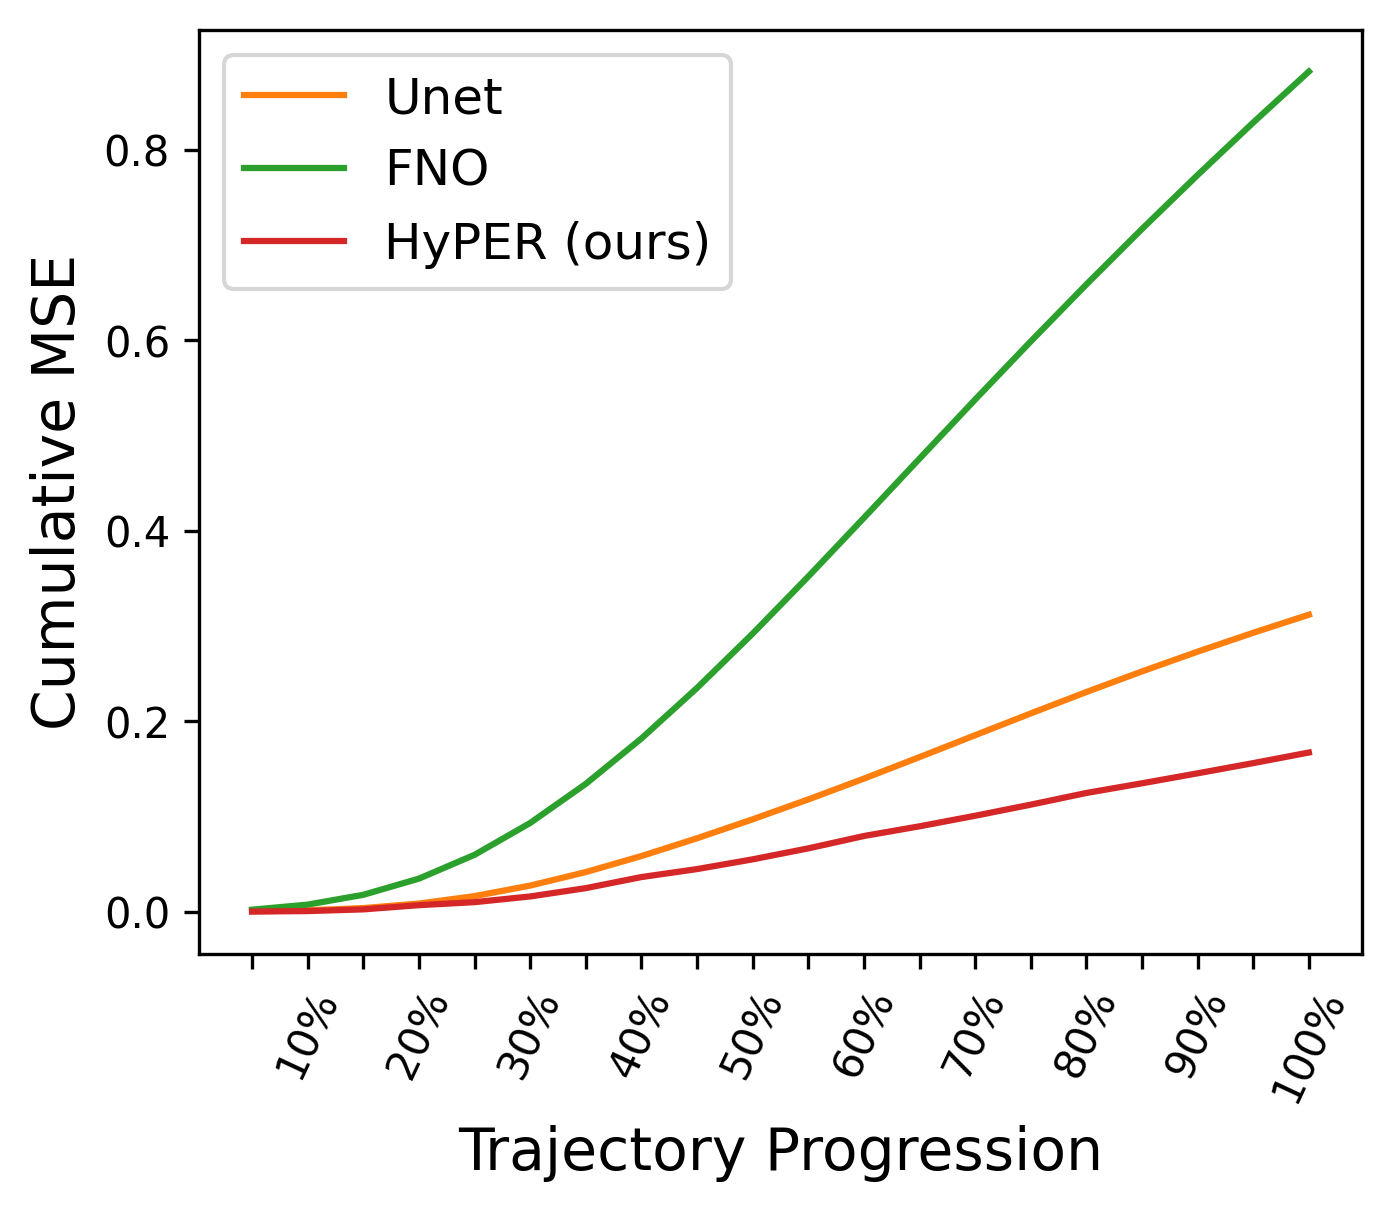

In [5]:
plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=12)
# baseline_mses
fig, axs = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(5, 4))
axs[0, 0].plot(np.mean(np.cumsum(unet_800_mses, axis=1), axis=0), label="Unet", color="#ff7f0e")
axs[0, 0].plot(np.mean(np.cumsum(fno_800_mses, axis=1), axis=0), label="FNO", color="#2ca02c")
axs[0, 0].plot(np.mean(np.cumsum(rl_mses, axis=1), axis=0), linestyle="solid", label="HyPER (ours)", color="#d62728")
axs[0, 0].set_ylabel("Cumulative MSE")
axs[0, 0].set_xlabel("Trajectory Progression")
#axs[0, 0].set_title("Navier-Stokes Cumulative MSE for Single Trajectory")
xtick_labels = ["5%", "10%", "15%", "20%", "25%", "30%", "35%", "40%", "45%", "50%", "55%", "60%", "65%", "70%", "75%", "80%", "85%", "90%", "95%", "100%"]
plt.xticks(np.arange(0, 20), xtick_labels, rotation=65)
for label in axs[0,0].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.legend()
plt.show()

# Plot Unet vs HyPER sample trajectory

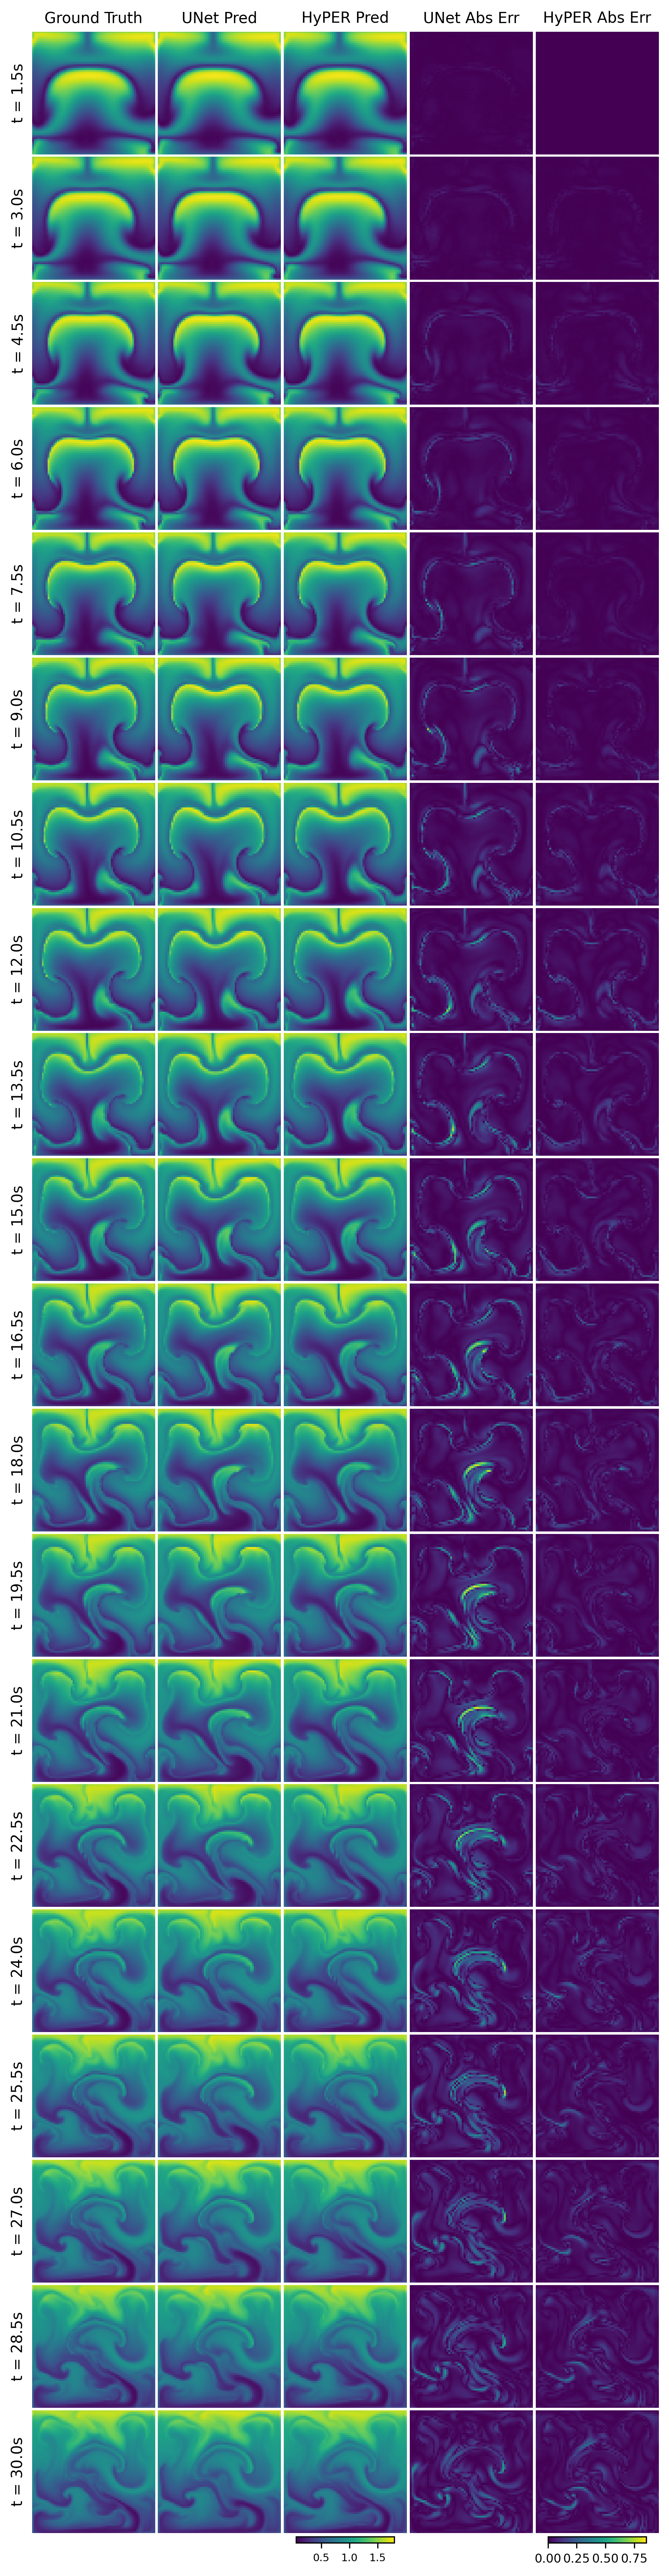

In [6]:
traj_idx = 138
num_timesteps = 20
timesteps = list(range(0, 20))
scaling = 1.5
fig = plt.figure(figsize=(5 * scaling, len(timesteps) * scaling))
gs = GridSpec(len(timesteps), 5, wspace=0, hspace=0.02, figure=fig)
fsize = 10
smoke_min = min(np.min(gts[traj_idx]), np.min(multistep_unet_preds[traj_idx]), np.min(unet_800_preds[traj_idx]), np.min(rl_preds[traj_idx]))
smoke_max = max(np.max(gts[traj_idx]), np.max(multistep_unet_preds[traj_idx]), np.max(unet_800_preds[traj_idx]), np.max(rl_preds[traj_idx]))
multistep_unet_errs = np.abs(gts[traj_idx] - multistep_unet_preds[traj_idx])
unet_800_errs = np.abs(gts[traj_idx] - unet_800_preds[traj_idx])
rl_errs = np.abs(gts[traj_idx] - rl_preds[traj_idx])
err_min = min(np.min(multistep_unet_errs), np.min(unet_800_errs), np.min(rl_errs))
err_max = max(np.max(multistep_unet_errs), np.max(unet_800_errs), np.max(rl_errs))

# plot ground truth
for i, t in enumerate(timesteps):
    ax = fig.add_subplot(gs[i, 0])
    ax.set_ylabel(f"t = {(t+1) * 1.5}s", fontsize=fsize)
    im = plot_scalar(ax, gts[traj_idx, t], min_val=smoke_min, max_val=smoke_max)
    if i == 0:
        ax.set_title("Ground Truth", fontsize=fsize)

# plot unet-800 prediction
for i, t in enumerate(timesteps):
    ax2 = fig.add_subplot(gs[i, 1])
    im2 = plot_scalar(ax2, unet_800_preds[traj_idx, t], min_val=smoke_min, max_val=smoke_max)
    if i == 0:
        ax2.set_title("UNet Pred", fontsize=fsize)

# plot unet-800 abs error
for i, t in enumerate(timesteps):
    ax3 = fig.add_subplot(gs[i, 3])
    im3 = plot_scalar(ax3, unet_800_errs[t], min_val=err_min, max_val=err_max)
    if i == 0:
        ax3.set_title("UNet Abs Err", fontsize=fsize)

# plot rl prediction
for i, t in enumerate(timesteps):
    ax2 = fig.add_subplot(gs[i, 2])
    im2 = plot_scalar(ax2, rl_preds[traj_idx, t], min_val=smoke_min, max_val=smoke_max)
    if i == 0:
        ax2.set_title("HyPER Pred", fontsize=fsize)

# plot rl abs error
for i, t in enumerate(timesteps):
    ax3 = fig.add_subplot(gs[i, 4])
    im3 = plot_scalar(ax3, rl_errs[t], min_val=err_min, max_val=err_max)
    if i == 0:
        ax3.set_title("HyPER Abs Err", fontsize=fsize)

axins = inset_axes(
    ax3,
    width="80%",  # width: 5% of parent_bbox width
    height="5%",  # height: 50%
    loc="lower center",
    bbox_to_anchor=(0.0, -0.08, 1, 1),
    bbox_transform=ax3.transAxes,
    borderpad=0,
)
axins.tick_params(labelsize=fsize * 0.8)
cb = fig.colorbar(im3, cax=axins, location="bottom")
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()

axins = inset_axes(
    ax2,
    width="80%",  # width: 5% of parent_bbox width
    height="5%",  # height: 50%
    loc="lower center",
    bbox_to_anchor=(0.0, -0.08, 1, 1),
    bbox_transform=ax2.transAxes,
    borderpad=0,
)
axins.tick_params(labelsize=fsize * 0.7)
cb = fig.colorbar(im2, cax=axins, location="bottom")
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()
